In [691]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import matplotlib.font_manager as fm

In [695]:
font_location = 'C:/Windows/Fonts/malgun.ttf' # 폰트 파일 이름, 디렉토리 주의
font_name = fm.FontProperties(fname = font_location).get_name()
matplotlib.rc('font', family=font_name)
plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정(필수)

# 현재 글꼴 확인
print(plt.rcParams['font.family'])

['Malgun Gothic']


# 기계학습 (60점)

### 리그오브레전드 게임 로그 데이터
data_path = './data/game_result.csv'
data_path = './data/log.csv'

데이터는 리그오브레전드 게임의 로그 데이터이다.    

---
리그오브 레전드 게임 룰
- 5명의 플레이어가 각자 다른 포지션에서 성장을 통해 아이템과 레벨을 올려 상대의 기지를 파괴하는 AOS장르의 게임
- 두 팀(red,blue)이 격돌, 각 팀은 5명의 플레이어가 5개의 포지션('T', 'J', 'M', 'B', 'S')을 하나씩 맡는다.   
---
데이터 설명
- game_result.csv : 게임 결과에 대한 정보
    - gameId: 게임명
    - win : 승리여부 True-승리, False-패배
    - TEAM: 팀 정보 (rea,blue)
    
- log.csv : 인게임 정보
    - time : 게임의 5분간격(~25분까지)
    - gameId : 게임명
    - variable : 6가지의 특정 행동 정보 
        - minionsKilled : 누적 몬스터 킬수
        - totalGold : 누적 골드획득량
        - totalDamageTaken : 누적 피해량
        - totalDamageDone : 누적 데미지
        - WARD_PLACED : 누적 시야 정보량
        - WARD_KILL : 누적 시야 제거량


In [129]:
gr =pd.read_csv('./data/game_result.csv')
display(gr.head())

log =pd.read_csv('./data/log.csv')
display(log.head())

,gameId,win,TEAM
0,JP1_340505476,False,blue
1,JP1_340505476,True,red
2,JP1_340611094,True,red
3,JP1_340611094,False,blue
4,JP1_340621330,True,red


,time,gameId,variable,value,POSITION,TEAM
0,5.0,LA1_1242504360,minionsKilled,33.0,T,blue
1,10.0,LA1_1242504360,minionsKilled,76.0,T,blue
2,15.0,LA1_1242504360,minionsKilled,110.0,T,blue
3,20.0,LA1_1242504360,minionsKilled,143.0,T,blue
4,25.0,LA1_1242504360,minionsKilled,167.0,T,blue


### 기계학습1
인게임 정보데이터는 5분간격의 누적 정보이다. each_variable 컬럼을 만들고 각 variable 별로 증가량값으로 채워넣어라 
<img src="./data/1.png" alt="alt_text" style="width:500px; float:left; ">

In [153]:
log['each_variable'] = log.groupby(['gameId','variable','POSITION','TEAM']).value.diff(1)
log['each_variable'] = log['each_variable'].fillna(log.value)

In [155]:
log.sort_values(by = ['gameId','variable']).head(10)

,time,gameId,variable,value,POSITION,TEAM,each_variable
93535,5.0,JP1_340505476,WARD_KILL,0.0,T,blue,0.0
93536,10.0,JP1_340505476,WARD_KILL,1.0,T,blue,1.0
93537,15.0,JP1_340505476,WARD_KILL,2.0,T,blue,1.0
93538,20.0,JP1_340505476,WARD_KILL,6.0,T,blue,4.0
93539,25.0,JP1_340505476,WARD_KILL,6.0,T,blue,0.0
199525,5.0,JP1_340505476,WARD_KILL,1.0,J,blue,1.0
199526,10.0,JP1_340505476,WARD_KILL,1.0,J,blue,0.0
199527,15.0,JP1_340505476,WARD_KILL,2.0,J,blue,1.0
199528,20.0,JP1_340505476,WARD_KILL,2.0,J,blue,0.0
199529,25.0,JP1_340505476,WARD_KILL,2.0,J,blue,0.0


### 기계학습2
하나의 행에 하나의 인게임 정보를 넣는 작업을 하고 blue 팀의 승패유무와 관련한 데이터를 추가하려한다.     
아래의 전처리 조건을 확인하여 작업을 진행하라

변환할 데이터프레임의 컬럼정보
- gameId (게임아이디)
- {팀명}_{포지션}_{variable} 형식으로 컬럼을 추가한다. variable 별로 아래 조건을 만족하는 값을 채워 넣는다.
    - {팀명}_{포지션}_minionsKilled : 25분의 minionsKilled value컬럼 값을 추가한다.
    - {팀명}_{포지션}_totalGold : each_variable의 다섯 구간 평균값을 추가한다.
    - {팀명}_{포지션}_totalDamageTaken : each_variable의 다섯 구간 평균값을 추가한다.
    - {팀명}_{포지션}_totalDamageDone : each_variable의 다섯 구간 분산값을 추가한다.
    - {팀명}_{포지션}_WARD_PLACED : 15분의 WARD_PLACED value컬럼 값을 추가한다.
    - {팀명}_{포지션}_WARD_KILL : each_variable의 max값을 추가한다.
- result : blue팀의 승리여부, 승리 : 1 , 패배 : 0 

아래와 같이 62개의 컬럼이 완성된다.    
<img src="./data/2.png" alt="alt_text" style="width:500px; float:left; ">

In [43]:
log.head(10)

,time,gameId,variable,value,POSITION,TEAM,each_variable
0,5.0,LA1_1242504360,minionsKilled,33.0,T,blue,33.0
1,10.0,LA1_1242504360,minionsKilled,76.0,T,blue,43.0
2,15.0,LA1_1242504360,minionsKilled,110.0,T,blue,34.0
3,20.0,LA1_1242504360,minionsKilled,143.0,T,blue,33.0
4,25.0,LA1_1242504360,minionsKilled,167.0,T,blue,24.0
5,5.0,LA1_1237407120,minionsKilled,16.0,T,blue,16.0
6,10.0,LA1_1237407120,minionsKilled,51.0,T,blue,35.0
7,15.0,LA1_1237407120,minionsKilled,62.0,T,blue,11.0
8,20.0,LA1_1237407120,minionsKilled,95.0,T,blue,33.0
9,25.0,LA1_1237407120,minionsKilled,120.0,T,blue,25.0


In [167]:
# {팀명}_{포지션}_minionsKilled : 25분의 minionsKilled value컬럼 값

minionsKilled = log.loc[(log.variable == 'minionsKilled')&(log.time == 25)]
minions_pivot = pd.pivot_table(data = minionsKilled, values = 'value', index = 'gameId', columns = ['TEAM','POSITION'], aggfunc='sum')

minions_col = []

for i in ['blue','red']:
    for j in ['B','J','M','S','T']:
        minions_col.append(f'{i}_{j}_minionsKilled')

minions_pivot.columns = minions_col

In [159]:
minions_pivot

,blue_B_minionsKilled,blue_J_minionsKilled,blue_M_minionsKilled,blue_S_minionsKilled,blue_T_minionsKilled,red_B_minionsKilled,red_J_minionsKilled,red_M_minionsKilled,red_S_minionsKilled,red_T_minionsKilled
gameId,,,,,,,,,,
JP1_340505476,54.0,14.0,140.0,168.0,188.0,168.0,22.0,167.0,52.0,173.0
JP1_340611094,181.0,28.0,197.0,26.0,169.0,194.0,48.0,148.0,17.0,155.0
JP1_340621330,192.0,61.0,202.0,37.0,97.0,189.0,15.0,147.0,24.0,183.0
JP1_340652067,203.0,68.0,166.0,36.0,191.0,217.0,22.0,177.0,34.0,148.0
JP1_341114767,123.0,21.0,192.0,33.0,196.0,207.0,40.0,173.0,8.0,182.0
...,...,...,...,...,...,...,...,...,...,...
NA1_4298502759,141.0,29.0,107.0,4.0,166.0,112.0,44.0,110.0,36.0,154.0
NA1_4298524350,111.0,51.0,103.0,2.0,152.0,115.0,15.0,159.0,5.0,111.0
NA1_4298572181,114.0,27.0,129.0,27.0,137.0,151.0,18.0,109.0,14.0,205.0


In [61]:
log.head()

,time,gameId,variable,value,POSITION,TEAM,each_variable
0,5.0,LA1_1242504360,minionsKilled,33.0,T,blue,33.0
1,10.0,LA1_1242504360,minionsKilled,76.0,T,blue,43.0
2,15.0,LA1_1242504360,minionsKilled,110.0,T,blue,34.0
3,20.0,LA1_1242504360,minionsKilled,143.0,T,blue,33.0
4,25.0,LA1_1242504360,minionsKilled,167.0,T,blue,24.0


In [179]:
# {팀명}_{포지션}_totalGold : each_variable의 다섯 구간 평균값

totalGold = log.loc[log.variable == 'totalGold']
totalGold_pivot = totalGold.groupby(['gameId','TEAM','POSITION']).each_variable.mean().unstack(-2).unstack()

totalGold_col = []

for i in ['blue','red']:
    for j in ['B','J','M','S','T']:
        totalGold_col.append(f'{i}_{j}_totalGold')

totalGold_pivot.columns = totalGold_col

In [181]:
totalGold_pivot

,blue_B_totalGold,blue_J_totalGold,blue_M_totalGold,blue_S_totalGold,blue_T_totalGold,red_B_totalGold,red_J_totalGold,red_M_totalGold,red_S_totalGold,red_T_totalGold
gameId,,,,,,,,,,
JP1_340505476,1432.0,1890.8,1702.4,2243.0,2291.2,2879.6,2161.8,2016.6,3062.4,1841.0
JP1_340611094,1832.8,1978.4,2382.4,1265.6,1661.6,2563.8,2288.6,2017.2,1694.2,2378.2
JP1_340621330,1531.4,1921.6,1800.6,1058.0,1482.4,2085.0,1866.4,2002.0,1344.6,2385.0
JP1_340652067,2060.0,1949.0,1454.6,1166.0,2130.0,2088.0,1849.0,2007.2,1280.4,1784.0
JP1_341114767,2048.2,2414.0,2732.2,1478.4,2406.2,2279.0,2291.2,2208.6,1159.8,1778.0
...,...,...,...,...,...,...,...,...,...,...
NA1_4298502759,2167.4,1901.4,2442.6,1282.0,1950.2,1594.4,2468.2,1823.2,2040.8,2427.6
NA1_4298524350,1535.6,2923.8,2317.0,1057.2,1699.2,1589.8,2419.0,2171.2,1341.4,1824.0
NA1_4298572181,1346.6,1776.2,1680.8,1600.2,1721.8,2102.0,2463.4,1825.4,1514.8,2350.0


In [187]:
# {팀명}_{포지션}_totalDamageTaken : each_variable의 다섯 구간 평균값

totalDamageTaken = log.loc[log.variable == 'totalDamageTaken']
totalDamageTaken_pivot = totalDamageTaken.groupby(['gameId','TEAM','POSITION']).each_variable.mean().unstack(-2).unstack()

totalDamageTaken_col = []

for i in ['blue','red']:
    for j in ['B','J','M','S','T']:
        totalDamageTaken_col.append(f'{i}_{j}_totalDamageTaken')

totalDamageTaken_pivot.columns = totalDamageTaken_col

In [189]:
totalDamageTaken_pivot

,blue_B_totalDamageTaken,blue_J_totalDamageTaken,blue_M_totalDamageTaken,blue_S_totalDamageTaken,blue_T_totalDamageTaken,red_B_totalDamageTaken,red_J_totalDamageTaken,red_M_totalDamageTaken,red_S_totalDamageTaken,red_T_totalDamageTaken
gameId,,,,,,,,,,
JP1_340505476,2925.4,4871.6,3237.8,3195.6,4372.2,2585.2,5060.4,3745.8,2245.2,3102.2
JP1_340611094,3372.8,5371.0,4497.0,3163.4,2947.0,2293.0,4318.2,3786.6,2010.8,4893.4
JP1_340621330,1974.2,3991.2,3072.0,1247.4,4410.6,2101.0,3605.2,3347.0,1393.6,3999.8
JP1_340652067,2049.4,3352.4,2368.4,1578.6,2735.2,2235.0,3933.4,2013.0,1714.4,2639.2
JP1_341114767,3189.8,5589.4,4417.0,3326.0,3379.0,3515.4,6912.4,3409.6,2363.2,4593.8
...,...,...,...,...,...,...,...,...,...,...
NA1_4298502759,3798.0,5064.0,4189.4,1995.2,4118.4,2843.8,5331.4,4306.0,2490.4,3024.4
NA1_4298524350,3894.6,4400.6,3998.2,1458.0,2620.4,1852.4,4611.6,2619.6,2490.6,4869.8
NA1_4298572181,2989.6,5274.6,2293.8,1611.6,4188.8,2217.8,5792.2,2808.2,1674.2,3751.8


In [195]:
# {팀명}_{포지션}_totalDamageDone : each_variable의 다섯 구간 분산값을 추가한다.

totalDamageDone = log.loc[log.variable == 'totalDamageDone']
totalDamageDone_pivot = totalDamageDone.groupby(['gameId','TEAM','POSITION']).each_variable.var().unstack(-2).unstack()

totalDamageDone_col = []

for i in ['blue','red']:
    for j in ['B','J','M','S','T']:
        totalDamageDone_col.append(f'{i}_{j}_totalDamageDone')

totalDamageDone_pivot.columns = totalDamageDone_col

In [197]:
totalDamageDone_pivot

,blue_B_totalDamageDone,blue_J_totalDamageDone,blue_M_totalDamageDone,blue_S_totalDamageDone,blue_T_totalDamageDone,red_B_totalDamageDone,red_J_totalDamageDone,red_M_totalDamageDone,red_S_totalDamageDone,red_T_totalDamageDone
gameId,,,,,,,,,,
JP1_340505476,1668168.7,172887896.3,49136531.7,177424708.3,148922218.3,478848920.7,118966128.5,200073169.0,41767070.2,183545848.7
JP1_340611094,331514369.0,22825609.2,294566980.3,11266988.8,57523118.5,434650533.7,157720967.8,148976978.7,2138257.7,125187464.3
JP1_340621330,50632784.3,68382439.3,74708097.7,1693634.3,75538560.2,243636692.8,69000347.5,108192947.8,1653210.0,99425437.7
JP1_340652067,314596388.8,284304645.7,30655408.3,983399.2,129388449.3,414167240.8,87998498.2,98574134.0,1866553.7,54995011.3
JP1_341114767,109897563.2,70287713.2,324894747.3,5640051.8,485757277.7,535034960.8,114827301.5,404138333.7,54790361.7,641461583.5
...,...,...,...,...,...,...,...,...,...,...
NA1_4298502759,53669496.2,58969408.7,18117352.2,7782209.3,131141031.2,55409490.0,122773228.8,49744218.3,9008243.5,62432031.7
NA1_4298524350,50080451.8,226948299.3,29615877.7,208447.3,11933315.7,25881801.7,145135915.3,78630897.7,811787.2,100925373.7
NA1_4298572181,15022532.3,42320033.5,54060739.0,7297632.3,70795312.5,218717453.8,124479109.7,47911632.3,4704732.5,370583681.2


In [342]:
# {팀명}_{포지션}_WARD_PLACED : 15분의 WARD_PLACED value컬럼 값
# 중복데이터가 존재하므로 pivot_table의 평균을 이용하여 구한다.

WARD_PLACED = log.loc[(log.variable == 'WARD_PLACED')&(log.time == 15)].reset_index(drop = True)
WARD_PLACED_pivot = pd.pivot_table(data = WARD_PLACED, values = 'value', index = 'gameId', columns = ['TEAM','POSITION'], aggfunc = 'mean')

WARD_PLACED_col = []

for i in ['blue','red']:
    for j in ['B','J','M','S','T']:
        WARD_PLACED_col.append(f'{i}_{j}_WARD_PLACED')

WARD_PLACED_pivot.columns = WARD_PLACED_col

WARD_PLACED_pivot

,blue_B_WARD_PLACED,blue_J_WARD_PLACED,blue_M_WARD_PLACED,blue_S_WARD_PLACED,blue_T_WARD_PLACED,red_B_WARD_PLACED,red_J_WARD_PLACED,red_M_WARD_PLACED,red_S_WARD_PLACED,red_T_WARD_PLACED
gameId,,,,,,,,,,
JP1_340505476,9.0,3.0,3.0,7.0,12.0,22.0,1.0,5.0,6.0,17.0
JP1_340611094,4.0,2.0,5.0,14.0,5.0,7.0,1.0,5.0,129.0,4.0
JP1_340621330,5.0,3.0,4.0,11.0,0.0,4.0,7.0,5.0,7.0,69.0
JP1_340652067,7.0,5.0,6.0,11.0,6.0,5.0,4.0,2.0,7.0,5.0
JP1_341114767,6.0,4.0,4.0,12.0,49.0,6.0,1.0,4.0,8.0,0.0
...,...,...,...,...,...,...,...,...,...,...
NA1_4298502759,4.0,1.0,4.0,8.0,1.0,4.0,2.0,6.0,6.0,9.0
NA1_4298524350,4.0,6.0,1.0,0.0,44.0,6.0,1.0,6.0,7.0,5.0
NA1_4298572181,5.0,2.0,5.0,11.0,5.0,4.0,21.0,4.0,8.0,4.0


In [321]:
# {팀명}_{포지션}_WARD_KILL : each_variable의 max값

WARD_KILL = log.loc[log.variable == 'WARD_KILL'].reset_index(drop = True)
WARD_KILL_pivot = WARD_KILL.groupby(['gameId','TEAM','POSITION']).each_variable.max().unstack(-2).unstack()

WARD_KILL_col = []

for i in ['blue','red']:
    for j in ['B','J','M','S','T']:
        WARD_KILL_col.append(f'{i}_{j}_WARD_KILL')

WARD_KILL_pivot.columns = WARD_KILL_col

In [323]:
WARD_KILL_pivot

,blue_B_WARD_KILL,blue_J_WARD_KILL,blue_M_WARD_KILL,blue_S_WARD_KILL,blue_T_WARD_KILL,red_B_WARD_KILL,red_J_WARD_KILL,red_M_WARD_KILL,red_S_WARD_KILL,red_T_WARD_KILL
gameId,,,,,,,,,,
JP1_340505476,6.0,1.0,2.0,4.0,4.0,1.0,1.0,1.0,8.0,2.0
JP1_340611094,2.0,4.0,2.0,2.0,2.0,2.0,6.0,2.0,5.0,1.0
JP1_340621330,2.0,2.0,2.0,6.0,0.0,0.0,4.0,0.0,2.0,1.0
JP1_340652067,1.0,4.0,0.0,4.0,5.0,3.0,2.0,2.0,3.0,2.0
JP1_341114767,2.0,3.0,1.0,2.0,0.0,2.0,1.0,3.0,2.0,9.0
...,...,...,...,...,...,...,...,...,...,...
NA1_4298502759,0.0,1.0,6.0,1.0,1.0,1.0,3.0,2.0,5.0,1.0
NA1_4298524350,2.0,3.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,1.0
NA1_4298572181,0.0,1.0,0.0,3.0,1.0,1.0,1.0,2.0,4.0,0.0


In [362]:
# result : blue팀의 승리여부, 승리 : 1 , 패배 : 0

result = gr.loc[gr.TEAM == 'blue',['gameId','win']].set_index('gameId')*1
result

,win
gameId,
JP1_340505476,0
JP1_340611094,0
JP1_340621330,0
JP1_340652067,0
JP1_341114767,1
...,...
NA1_4298502759,0
NA1_4298524350,0
NA1_4298572181,0


- 테이블 병합

In [366]:
m1 = pd.merge(minions_pivot, totalGold_pivot, left_index = True, right_index = True)
m2 = pd.merge(m1, totalDamageTaken_pivot, left_index = True, right_index = True)
m3 = pd.merge(m2, totalDamageDone_pivot, left_index = True, right_index = True)
m4 = pd.merge(m3, WARD_PLACED_pivot, left_index = True, right_index = True)
m5 = pd.merge(m4, WARD_KILL_pivot, left_index = True, right_index = True)
log_final = pd.merge(m5, result, left_index = True, right_index = True).reset_index()
log_final

,gameId,blue_B_minionsKilled,blue_J_minionsKilled,blue_M_minionsKilled,blue_S_minionsKilled,blue_T_minionsKilled,red_B_minionsKilled,red_J_minionsKilled,red_M_minionsKilled,red_S_minionsKilled,...,blue_J_WARD_KILL,blue_M_WARD_KILL,blue_S_WARD_KILL,blue_T_WARD_KILL,red_B_WARD_KILL,red_J_WARD_KILL,red_M_WARD_KILL,red_S_WARD_KILL,red_T_WARD_KILL,win
0,JP1_340505476,54.0,14.0,140.0,168.0,188.0,168.0,22.0,167.0,52.0,...,1.0,2.0,4.0,4.0,1.0,1.0,1.0,8.0,2.0,0
1,JP1_340611094,181.0,28.0,197.0,26.0,169.0,194.0,48.0,148.0,17.0,...,4.0,2.0,2.0,2.0,2.0,6.0,2.0,5.0,1.0,0
2,JP1_340621330,192.0,61.0,202.0,37.0,97.0,189.0,15.0,147.0,24.0,...,2.0,2.0,6.0,0.0,0.0,4.0,0.0,2.0,1.0,0
3,JP1_340652067,203.0,68.0,166.0,36.0,191.0,217.0,22.0,177.0,34.0,...,4.0,0.0,4.0,5.0,3.0,2.0,2.0,3.0,2.0,0
4,JP1_341114767,123.0,21.0,192.0,33.0,196.0,207.0,40.0,173.0,8.0,...,3.0,1.0,2.0,0.0,2.0,1.0,3.0,2.0,9.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3370,NA1_4298502759,141.0,29.0,107.0,4.0,166.0,112.0,44.0,110.0,36.0,...,1.0,6.0,1.0,1.0,1.0,3.0,2.0,5.0,1.0,0
3371,NA1_4298524350,111.0,51.0,103.0,2.0,152.0,115.0,15.0,159.0,5.0,...,3.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,1.0,0
3372,NA1_4298572181,114.0,27.0,129.0,27.0,137.0,151.0,18.0,109.0,14.0,...,1.0,0.0,3.0,1.0,1.0,1.0,2.0,4.0,0.0,0
3373,NA1_4298588683,108.0,30.0,153.0,37.0,181.0,164.0,6.0,128.0,12.0,...,5.0,0.0,1.0,1.0,1.0,2.0,2.0,5.0,3.0,1


### 기계학습 3
데이터 EDA 및 시각화

- 각 팀의 포지션별 minionsKilled는 전반적으로 특정 범위에 데이터가 집중되어있는 것으로 확인된다. 이상치가 존재할 수 있다.
- 각 팀의 포지션별 totalGold와 totalDamageTaken(평균) 변수는 종 모양의 대칭 분포를 이루고 있는 것으로 확인된다.
- 각 팀의 포지션별 totalDamageDone(분산) 은 작은 값의 범위에 데이터가 집중되어있다. 받은 데미지의 분산은 크지 않은 것이 확인된다.
- 각 팀의 포지션별 WARD_PLACED는 전반적으로 특정 범위에 데이터가 집중되어있는 것으로 확인된다. 이상치가 존재할 수 있다.
- 각 팀의 포지션별 WARD_KILL은 오른쪽으로 치우친 분포를 보이고 있다.

In [368]:
log_final.describe()

,blue_B_minionsKilled,blue_J_minionsKilled,blue_M_minionsKilled,blue_S_minionsKilled,blue_T_minionsKilled,red_B_minionsKilled,red_J_minionsKilled,red_M_minionsKilled,red_S_minionsKilled,red_T_minionsKilled,...,blue_J_WARD_KILL,blue_M_WARD_KILL,blue_S_WARD_KILL,blue_T_WARD_KILL,red_B_WARD_KILL,red_J_WARD_KILL,red_M_WARD_KILL,red_S_WARD_KILL,red_T_WARD_KILL,win
count,3375.000000,3375.000000,3375.000000,3375.000000,3375.000000,3375.000000,3375.000000,3375.000000,3375.000000,3375.000000,...,3375.000000,3375.000000,3375.000000,3375.000000,3375.000000,3375.000000,3375.000000,3375.000000,3375.000000,3375.000000
mean,164.539556,36.679407,155.056593,33.314074,161.475259,165.246519,36.875852,156.226370,33.912296,162.185481,...,2.040889,1.433185,2.716148,1.296593,1.691556,2.022519,1.451259,2.678222,1.333630,0.513185
std,55.024272,33.604084,53.408438,34.200597,56.706170,54.089310,35.965393,54.031794,36.316612,53.999379,...,1.332681,1.073566,1.545983,1.350987,1.251426,1.363671,1.127567,1.597693,1.533496,0.499900
min,5.000000,0.000000,2.000000,0.000000,0.000000,3.000000,0.000000,4.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,143.000000,19.000000,131.000000,15.000000,137.000000,143.000000,18.000000,133.000000,15.000000,138.000000,...,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,0.000000
50%,163.000000,28.000000,153.000000,28.000000,159.000000,165.000000,27.000000,155.000000,28.000000,160.000000,...,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000
75%,182.000000,41.000000,174.000000,37.000000,181.000000,183.000000,40.000000,177.000000,37.000000,182.000000,...,3.000000,2.000000,4.000000,2.000000,2.000000,3.000000,2.000000,4.000000,2.000000,1.000000
max,1085.000000,324.000000,705.000000,414.000000,760.000000,875.000000,416.000000,665.000000,540.000000,845.000000,...,12.000000,7.000000,11.000000,18.000000,14.000000,13.000000,9.000000,12.000000,20.000000,1.000000


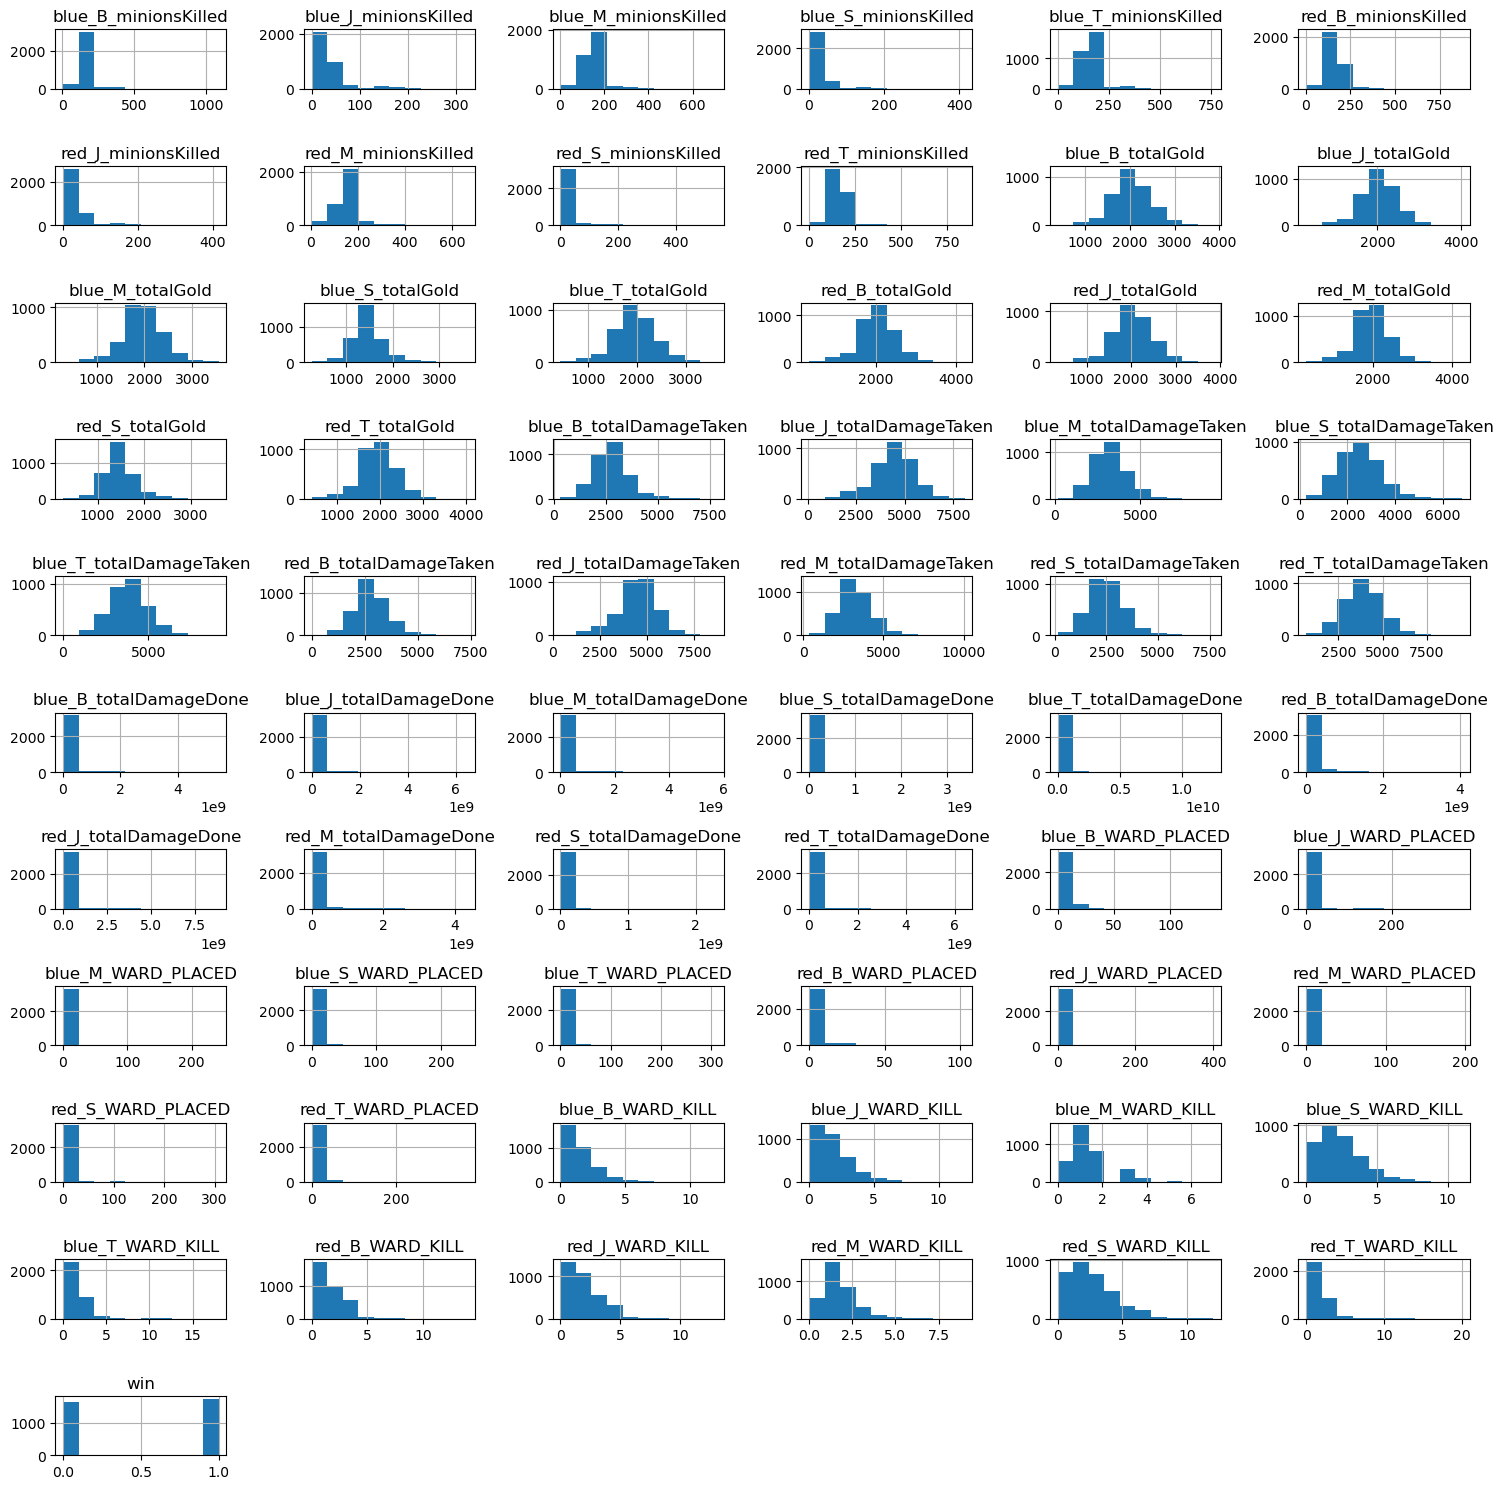

In [382]:
log_final.hist(figsize = (15, 15), layout = (11, 6))
plt.tight_layout()
plt.show()

### 기계학습4      
전처리한 데이터를 바탕으로 승리 예측 분류 모델을 만들려고한다. 아래의 기준으로 모델링을 하고 평가를 진행하라     
- 랜덤포레스트와 그래디언트 부스팅으로 학습한다
- 각 모델별로 3개의 파라미터들을 2개 이상 조합하여 최적의 파라미터를 찾는다.   
- 학습데이터는 70%를 사용한다
- auc값으로 평가를 진행하며 ROC Curve를 그려라

In [1173]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

- 학습데이터 분리

In [1177]:
X = log_final.drop(columns = ['gameId','win']).copy()
y = log_final.win.copy()

In [1179]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

- 데이터 스케일링

In [1183]:
sc = StandardScaler()

X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

- 랜덤포레스트 모델링

In [1185]:
rf_model = RandomForestClassifier()
rf_param = {'n_estimators' : [100, 200], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 3]}

In [1187]:
rf_gb = GridSearchCV(estimator= rf_model, param_grid= rf_param, scoring = 'roc_auc')

In [1189]:
rf_gb.fit(X_train_sc, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'min_samples_leaf': [1, 3],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='roc_auc')

- 그래디언트 부스팅

In [1190]:
grad_model = GradientBoostingClassifier()
grad_param = {'n_estimators' : [100, 200], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 3]}

In [1191]:
grad_gb = GridSearchCV(estimator= grad_model, param_grid= grad_param, scoring = 'roc_auc')

In [1192]:
grad_gb.fit(X_train_sc, y_train)

GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid={'min_samples_leaf': [1, 3],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='roc_auc')

- 모델 평가
  - GridSearch로 최적의 파라미터를 찾아 학습한 결과 Random Forest 모델의 auc가 0.9272으로 그래디언트 부스팅에 비해 다소 우수한 것으로 나타난다.

In [1197]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [1199]:
rf_pred = rf_gb.predict(X_test_sc)
grad_pred = grad_gb.predict(X_test_sc)

fpr_rf, tpr_rf, threshold_rf = roc_curve(y_test, rf_pred)
fpr_grad, tpr_grad, threshold_grad = roc_curve(y_test, grad_pred)

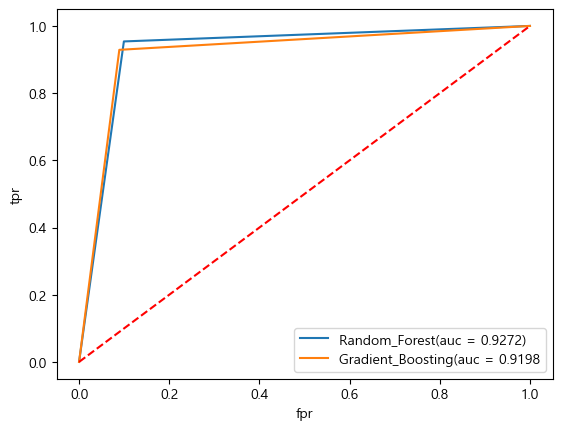

In [1201]:
plt.plot(fpr_rf, tpr_rf, label = f'Random_Forest(auc = {auc(fpr_rf, tpr_rf):.4f})')
plt.plot(fpr_grad, tpr_grad, label = f'Gradient_Boosting(auc = {auc(fpr_grad, tpr_grad):.4f}')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend()
plt.plot([0,1],[0,1], 'r--')
plt.show()

### 기계학습5 
성능이 우수한 모델로부터 변수중요도를 시각화하고 해석하라

- 분석 결과 Blue_B_totalGold > red_J_totalGold > blue_J_totalGold > red_B_totalGold 가 Blue의 승리에 가장 많은 영향을 미친것으로 나타난다.
- 전반적으로 totalGold의 변수 중요도가 높은데 누적 골드 획득량, 즉 자원이 승패를 많이 좌우했던 것으로 판단된다.

In [1208]:
rf_best = rf_gb.best_estimator_

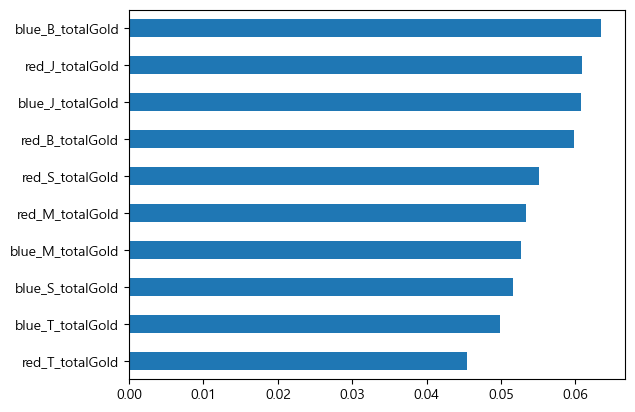

In [1216]:
pd.Series(rf_best.feature_importances_, index = X_test.columns).sort_values(ascending = False)[:10][::-1].plot(kind = 'barh')
plt.show()

### 폐처리 시설의 여러 대기 측정정보

data_path = './data/mc.csv'

데이터는 특정 폐수 처리시설 주변의 여러 측정센서를 통해 5분간격으로 측정한 데이터이다.
- 매 5분동안 최대 24개의 주변 측정소에서 여러 정보들을 수집한다. 

In [570]:
import pandas as pd
df = pd.read_csv('./data/mc.csv')
df.head()

,측정장소,측정일시,온도,습도,풍향,풍속,황화수소,암모니아,휘발성유기화합물,강수량,기압,초미세먼지
0,1,2022-01-10 09:00:00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0,0.0,0.0
1,3,2022-01-10 09:00:00,0.00,0.0,0.0,0.00,9.2,0.0,0.0,0,0.0,0.0
2,4,2022-01-10 09:00:00,0.00,0.0,0.0,0.00,0.8,0.0,0.0,0,0.0,0.0
3,5,2022-01-10 09:00:00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0,0.0,0.0
4,6,2022-01-10 09:00:00,12.14,81.9,0.3,0.03,6.0,0.0,0.0,0,1019.5,113.8


In [539]:
df.측정일시 = pd.to_datetime(df.측정일시)

### 기계학습5    
다음의 기준으로 전처리를 시행하고 시각화를 포함한 EDA를 진행하라
1. 측정일시별로 측정장소 상관없이 각 측정값들의 최대값 1개만 남겨라. 
2. 1의 전처리 후 온도 ~ 초미세먼지 값이 모두 0인 데이터 행은 제거하라

In [572]:
df.강수량.value_counts()

강수량
0    978936
Name: count, dtype: int64

In [541]:
target_df = df.groupby('측정일시').max().drop(columns = '측정장소')
target_df = target_df.loc[~((target_df.온도 == 0) | (target_df.초미세먼지 == 0))]
target_df

,온도,습도,풍향,풍속,황화수소,암모니아,휘발성유기화합물,강수량,기압,초미세먼지
측정일시,,,,,,,,,,
2022-01-10 09:00:00,16.67,81.90,1.0,0.12,14.5,17.0,5849.5,0,1023.2,985.0
2022-01-10 09:05:00,16.78,81.65,1.0,0.12,14.0,17.0,6236.0,0,1023.2,985.0
2022-01-10 09:10:00,16.86,81.85,1.0,0.11,14.0,15.0,6045.8,0,1023.1,985.0
2022-01-10 09:15:00,17.01,81.50,1.0,0.10,13.0,13.4,5617.0,0,1023.2,985.0
2022-01-10 09:20:00,17.17,81.10,1.0,0.10,18.0,17.0,5261.0,0,1023.2,985.0
...,...,...,...,...,...,...,...,...,...,...
2022-05-31 23:40:00,25.61,51.47,1.0,0.21,16.8,11.0,76.1,0,1007.2,28.0
2022-05-31 23:45:00,25.64,50.56,1.0,0.28,19.1,7.4,75.5,0,1007.1,28.0
2022-05-31 23:50:00,25.67,50.33,1.0,0.26,10.0,10.0,103.2,0,1007.1,28.0


- 데이터 시각화
  - 그래프에서 데이터가 존재하지 않는 기간이 있는 것이 확인된다.

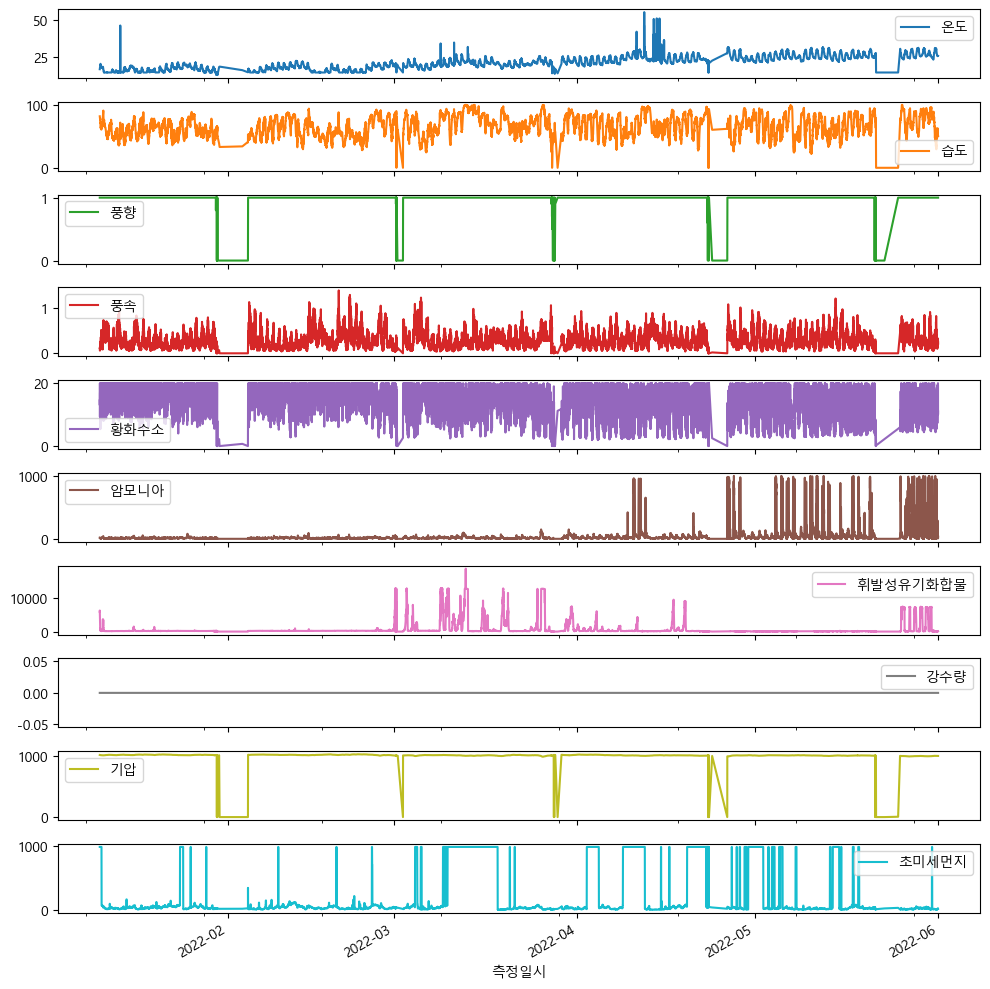

In [707]:
target_df.plot(subplots = True, figsize = (10, 10))
plt.tight_layout()
plt.show()

### 기계학습6     
데이터의 측정시간대를 일별 6시간 간격(0 ~ 5시 ,6~12시 ..)으로 나누어 각 컬럼의 수치 평균값을 내라. 
각 시간 구간을 0,1,2,3으로 표기하고 date_split 컬럼을 추가한다.

In [630]:
target_6h_split = target_df.resample('6h').mean()
target_6h_split.insert(loc = 0, column = 'date_split', value = [0, 1, 2, 3] * int((568/4)))

In [710]:
target_6h_split = target_6h_split.dropna()

### 기계학습7     
변수간 상관관계를 확인하고 date_split의 값이 2과 3인 데이터를 필터하고     
각 독립변수들의 date_split 값이 2,3 그룹의 차이가 존재하는지 통계 검정을 실시하라

- 변수간 상관관계 확인
  - 강수량은 모든 값이 0으로 상관관계가 확인되지 않으므로 분석에서 제외한다.
  - 양의 상관관계 확인 결과 풍향-기압 > 온도-암모니아 > 풍향-황화수소 > 습도-휘발성유기화합물 순으로 높은 상관관계가 확인된다.
  - 음의 상관관계 확인 결과 온도-황화수소에서 높은 상관관계가 확인된다.

In [712]:
target_6h_split_2 = target_6h_split.drop(columns = '강수량')

In [714]:
target_6h_split_2.loc[:, '온도':].corr()

,온도,습도,풍향,풍속,황화수소,암모니아,휘발성유기화합물,기압,초미세먼지
온도,1.000000,0.146214,0.134683,0.216093,-0.524713,0.545521,0.042411,0.132012,0.241315
습도,0.146214,1.000000,0.221113,-0.225630,0.197818,0.092830,0.429492,0.322057,0.233495
풍향,0.134683,0.221113,1.000000,0.248488,0.474185,0.074597,0.057144,0.697461,0.071538
풍속,0.216093,-0.225630,0.248488,1.000000,-0.094204,0.194126,-0.085407,0.234838,-0.030884
황화수소,-0.524713,0.197818,0.474185,-0.094204,1.000000,-0.273760,0.014731,0.398364,-0.084964
암모니아,0.545521,0.092830,0.074597,0.194126,-0.273760,1.000000,0.035086,0.040398,-0.021281
휘발성유기화합물,0.042411,0.429492,0.057144,-0.085407,0.014731,0.035086,1.000000,0.035415,0.098018
기압,0.132012,0.322057,0.697461,0.234838,0.398364,0.040398,0.035415,1.000000,0.050834
초미세먼지,0.241315,0.233495,0.071538,-0.030884,-0.084964,-0.021281,0.098018,0.050834,1.000000


In [716]:
from itertools import combinations

corr = []
col = []

for col1, col2 in combinations(target_6h_split_2.loc[:, '온도':].columns, 2):
    corr.append(target_6h_split_2[[col1,col2]].corr().iloc[0,1])
    col.append(f'{col1}-{col2}')

In [718]:
corr_df = pd.DataFrame(corr, index = col, columns = ['corr']).sort_values(by = 'corr', ascending = False)
corr_df

,corr
풍향-기압,0.697461
온도-암모니아,0.545521
풍향-황화수소,0.474185
습도-휘발성유기화합물,0.429492
황화수소-기압,0.398364
습도-기압,0.322057
풍향-풍속,0.248488
온도-초미세먼지,0.241315
풍속-기압,0.234838
습도-초미세먼지,0.233495


- 그룹 2와 3의 차이 검정
  - 측정 장소가 다양하므로 각 변수별 독립표본 t-test를 이용한다.
  - 표본의 크기가 충분히 크므로 t분포는 정규분포로 근사된다.
  - 가설설정
    - 귀무가설 : date_split 2와 3별 각 변수의 평균에 차이가 없다.
    - 대립가설 : date_split 2와 3별 각 변수의 평균에 차이가 있다.
  - 분석 결과 유의수준 0.05에서 온도, 습도,	풍향, 풍속, 황화수소, 암모니아, 휘발성유기화합물 평균에 차이가 있는 것으로 나타난다.

In [720]:
target_6h_split_23 = target_6h_split.loc[target_6h_split.date_split.isin([2, 3])]
target_6h_split_23

,date_split,온도,습도,풍향,풍속,황화수소,암모니아,휘발성유기화합물,강수량,기압,초미세먼지
측정일시,,,,,,,,,,,
2022-01-10 18:00:00,2,17.557639,77.811389,1.0,0.266667,13.662500,20.626389,1288.502778,0.0,1017.811111,60.293056
2022-01-11 00:00:00,3,14.706944,71.981250,1.0,0.460000,15.013889,7.923611,287.952778,0.0,1018.061111,42.569444
2022-01-11 18:00:00,2,14.440000,54.272222,1.0,0.324722,15.711111,12.615278,138.105556,0.0,1025.059722,22.513889
2022-01-12 00:00:00,3,14.440000,67.095556,1.0,0.150417,17.486111,10.169444,141.508333,0.0,1025.030556,45.944444
2022-01-12 18:00:00,2,14.477500,46.159722,1.0,0.187361,16.737500,8.537500,150.068056,0.0,1022.466667,24.916667
...,...,...,...,...,...,...,...,...,...,...,...
2022-05-30 00:00:00,3,25.687639,89.135694,1.0,0.128194,14.341667,95.693056,6808.959722,0.0,1002.636111,35.916667
2022-05-30 18:00:00,2,25.280139,89.577083,1.0,0.256389,12.845833,201.636111,4426.073611,0.0,1003.325000,176.694444
2022-05-31 00:00:00,3,23.826389,85.396528,1.0,0.165417,16.883333,27.770833,122.686111,0.0,1005.355556,16.530556


In [722]:
date_split_2 = target_6h_split_23.loc[target_6h_split_23.date_split == 2,'온도':]
date_split_3 = target_6h_split_23.loc[target_6h_split_23.date_split == 3,'온도':]

In [646]:
from scipy.stats import ttest_ind

In [742]:
col_lst = []
p_value = []

for col in date_split_2.columns:
    col_lst.append(col)
    p_value.append(ttest_ind(a = date_split_2[col], b = date_split_3[col]).pvalue)

- 분석 결과 유의수준 

In [750]:
p_value_df = pd.DataFrame(p_value, index = col_lst, columns = ['p_value'])
p_value_df

,p_value
온도,1.200428e-01
습도,2.056405e-04
풍향,3.851146e-01
풍속,6.962676e-09
황화수소,3.117181e-01
암모니아,1.048576e-04
휘발성유기화합물,1.186551e-02
강수량,NaN
기압,5.153748e-01
초미세먼지,8.210293e-01


### 기계학습 8
전처리한 데이터를 바탕으로 초미세먼지를 예측하는 모델을 만들려고한다.     
적절한 변수 처리를 하고 다중선형회귀, 랜덤포레스트 모델을 통해 모델 평가를 실시하라.
rmse로 평가를 진행한다. 

- 강수량은 값이 0이며 풍향 또한 대부분의 값이 1로 초미세먼지의 변동을 설명하는 변수로 적절하지 않으므로 제거한다.

In [762]:
target_6h_split_23.풍향.value_counts()

풍향
1.000000    251
0.000000      2
0.997222      1
0.890385      1
0.835714      1
0.390909      1
0.920635      1
Name: count, dtype: int64

In [766]:
modeling_df = target_6h_split_23.drop(columns = ['date_split','강수량'])

In [772]:
modeling_df.head()

,온도,습도,풍향,풍속,황화수소,암모니아,휘발성유기화합물,기압,초미세먼지
측정일시,,,,,,,,,
2022-01-10 18:00:00,17.557639,77.811389,1.0,0.266667,13.662500,20.626389,1288.502778,1017.811111,60.293056
2022-01-11 00:00:00,14.706944,71.981250,1.0,0.460000,15.013889,7.923611,287.952778,1018.061111,42.569444
2022-01-11 18:00:00,14.440000,54.272222,1.0,0.324722,15.711111,12.615278,138.105556,1025.059722,22.513889
2022-01-12 00:00:00,14.440000,67.095556,1.0,0.150417,17.486111,10.169444,141.508333,1025.030556,45.944444
2022-01-12 18:00:00,14.477500,46.159722,1.0,0.187361,16.737500,8.537500,150.068056,1022.466667,24.916667


In [774]:
X_2 = modeling_df.drop(columns = '초미세먼지')
y_2 = modeling_df.초미세먼지

In [776]:
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size= 0.3, random_state=42)

In [758]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

In [760]:
lr_model = LinearRegression()
rf_reg_model = RandomForestRegressor()

In [780]:
lr_model.fit(X_2_train, y_2_train)

LinearRegression()

In [782]:
rf_reg_model.fit(X_2_train, y_2_train)

RandomForestRegressor()

In [784]:
lr_pred = lr_model.predict(X_2_test)
rf_reg_pred = rf_reg_model.predict(X_2_test)

In [786]:
lr_rmse = root_mean_squared_error(y_2_test, lr_pred)
rf_reg_rmse = root_mean_squared_error(y_2_test, rf_reg_pred)

- RMSE는 예측값과 실제값의 오차제곱합에 제곱근을 취한 것으로, 작을 수록 모델의 예측 성능이 우수한 것으로 평가된다.
- 본 분석의 경우 다중선형회귀모델의 rmse가 약 316.48로 랜덤포레스트회귀모형보다 우수한 것으로 판단된다.

In [788]:
lr_rmse, rf_reg_rmse

(316.4766051994078, 324.3212513315671)

# 통계 (40점)

## 통계1

### 통계1-1      
어느 지역의 미세 지진 발생 간격은 평균 10년이다. 이 지진 발생 간격은 지수 분포를 따른다고 가정한다.      
최근 지진 이후 5년이 지난 시점에서 7년 이내에 지진이 발생하지 않을 확률은?     

- 지수분포는 연속 시간에서 첫 번째 성공이 일어나기까지의 시간에 대한 확률분포이다.
  - 지진 미발생을 성공 사건으로 인식하여 확률을 구한다.
  - 최근 지진 이후 5년이 지난 시점에서 7년 이내 지진 발생 확률을 구하므로 12년 이내 지진이 발생하지 않을 확률을 구한다.

In [1091]:
from scipy.stats import expon

In [1234]:
rv = expon(scale = 10) # scale : 람다값의 역수

In [1250]:
p_e12 = rv.cdf(12)
p_e12

0.6988057880877978

### 통계 1-2
지난 지진 발생 후 15년이 지났다. 8년 이내에 지진이 발생할 확률은?

- 최근 지진 이후 15년이 지난 시점에서 8년 이내 지진 발생 확률을 구하므로 23년 이내 지진이 발생하지 않을 확률을 구한다.

In [1253]:
p_e23 = rv.cdf(23)
p_e23

0.8997411562771962

## 통계2
data_path = './data/s1.csv'     
데이터는 식단과 운동강도에 따라 감량 체중을 기록한 다이어트 프로그램 결과이다. 

In [791]:
import pandas as pd
df_s1 =pd.read_csv('./data/s1.csv')
df_s1.head()

,유저,식단,운동,감량체중
0,ID-1,저탄고단,저강도,5.496714
1,ID-2,저탄고단,저강도,4.861736
2,ID-3,저탄고단,저강도,5.647689
3,ID-4,저탄고단,저강도,6.523030
4,ID-5,저탄고단,저강도,4.765847


In [806]:
df_s1.shape

(160, 5)

### 통계 2-1
식단과 운동의 조합으로 만들어지는 4개의 그룹들의 각 그룹의 정규성과 그룹간 등분산성을 확인하라    

In [801]:
df_s1['식단-운동'] = df_s1['식단'] + '-' + df_s1['운동']

- 정규성 검정
  - 표본의 크기가 160으로 크지 않으므로 shapiro 검정을 적용한다.
  - 귀무가설 : 자료의 모집단이 정규분포를 따른다 / 대립가설 : 자료의 모집단이 정규분포를 따르지 않는다.

In [816]:
from scipy.stats import shapiro

for col in df_s1['식단-운동'].unique():
    print(f'{col} 정규성검정 결과 p_value = {shapiro(df_s1.loc[df_s1['식단-운동'] == col, '감량체중']).pvalue:.4f}')

저탄고단-저강도 정규성검정 결과 p_value = 0.6604
저탄고단-고강도 정규성검정 결과 p_value = 0.3709
저탄고지-저강도 정규성검정 결과 p_value = 0.3269
저탄고지-고강도 정규성검정 결과 p_value = 0.1624


- 등분산성검정
  - levene 검정을 적용한다.
  - 귀무가설 : 두 모집단이 등분산이다. / 대립가설 : 두 모집단이 이분산이다.

In [824]:
from scipy.stats import levene

for col1, col2 in combinations(df_s1['식단-운동'].unique(), 2):
    target1 = df_s1.loc[df_s1['식단-운동'] == col1, '감량체중']
    target2 = df_s1.loc[df_s1['식단-운동'] == col2, '감량체중']
    print(f'{col1} / {col2} 등분산성검정 결과 p_value = {levene(target1, target2).pvalue:.4f}')

저탄고단-저강도 / 저탄고단-고강도 등분산성검정 결과 p_value = 0.9633
저탄고단-저강도 / 저탄고지-저강도 등분산성검정 결과 p_value = 0.3333
저탄고단-저강도 / 저탄고지-고강도 등분산성검정 결과 p_value = 0.7046
저탄고단-고강도 / 저탄고지-저강도 등분산성검정 결과 p_value = 0.3168
저탄고단-고강도 / 저탄고지-고강도 등분산성검정 결과 p_value = 0.7416
저탄고지-저강도 / 저탄고지-고강도 등분산성검정 결과 p_value = 0.1882


- 검정 결과 데이터의 정규성과 등분산성 모두 충족하는 것으로 나타난다.

### 통계 2-2
이원분산분석을 진행하려한다. 2-1의 결과를 바탕으로 모수,비모수 방법을 결정하고 주효과에 대한 가설과 교호작용 효과에 대한 가설을 설정하라    

- 데이터가 정규성 및 등분산성을 충족하므로 모수적 방법인 이원분산분석을 사용하여 검정한다.
  - 귀무가설 1 : 식단에 따른 감량체중에 차이가 없다.
  - 귀무가설 2 : 운동에 따른 감량체중에 차이가 없다.
  - 귀무가설 3 : 식단과 운동의 상호작용 효과가 없다.
  - 대립가설 1 : 식단에 따른 감량체중에 차이가 있다.
  - 대립가설 2 : 운동에 따른 감량체중에 차이가 있다.
  - 대립가설 3 : 식단과 운동의 상호작용 효과가 있다.

### 통계2-3
통계검정을 실시하고 결과를 해석하라.    



- 검정 결과 유의수준 0.05 하에서 식단과 운동 각각이 감량체중의 p_value는 통계적으로 유의한 것으로 확인된다.
- 그러나 두 변수의 교호항의 p_value는 약 0.37로, 통계적으로 유의하지 않은 것으로 확인된다.
- 따라서 식단과 운동 각각은 감량체중에 영향을 주는 것으로 볼 수 있지만,

  식단의 종류에 따라서 운동이 감량체중에 미치는 영향이 달라지거나
  
  운동의 종류에 따라서 식단이 감량체중에 미치는 영향이 달라지지는 않는 것으로 보인다.

In [831]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

formula = '감량체중 ~ C(식단) + C(운동) + C(식단):C(운동)'

anova_model = ols(formula, df_s1).fit()

In [837]:
aov_table = anova_lm(anova_model, type = 3)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
C(식단),1.0,16.257434,16.257434,18.352972,3.198226e-05
C(운동),1.0,70.040700,70.040700,79.068753,1.401288e-15
C(식단):C(운동),1.0,0.714673,0.714673,0.806792,3.704546e-01
Residual,156.0,138.187955,0.885820,NaN,NaN


### 통계 2-4
사후검정을 실시하고 결과를 해석하라.

- tukey의 사후검정을 적용한다.
  - 검정 결과 저탄고단-고강도 / 저탄고지-고강도의 방법의 제외한 나머지 방법에서 감량체중의 차이가 유의미한 것으로 나타난다.

In [850]:
from statsmodels.stats.multicomp import MultiComparison

mc = MultiComparison(data = df_s1['감량체중'], groups = df_s1['식단-운동'])

tukeyhsd = mc.tukeyhsd(alpha=0.05)
tukeyhsd.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
저탄고단-고강도,저탄고단-저강도,-1.1896,0.0,-1.7361,-0.6431,True
저탄고단-고강도,저탄고지-고강도,-0.5039,0.0824,-1.0504,0.0427,False
저탄고단-고강도,저탄고지-저강도,-1.9608,0.0,-2.5073,-1.4142,True
저탄고단-저강도,저탄고지-고강도,0.6857,0.0074,0.1392,1.2323,True
저탄고단-저강도,저탄고지-저강도,-0.7712,0.0019,-1.3177,-0.2247,True
저탄고지-고강도,저탄고지-저강도,-1.4569,0.0,-2.0035,-0.9104,True


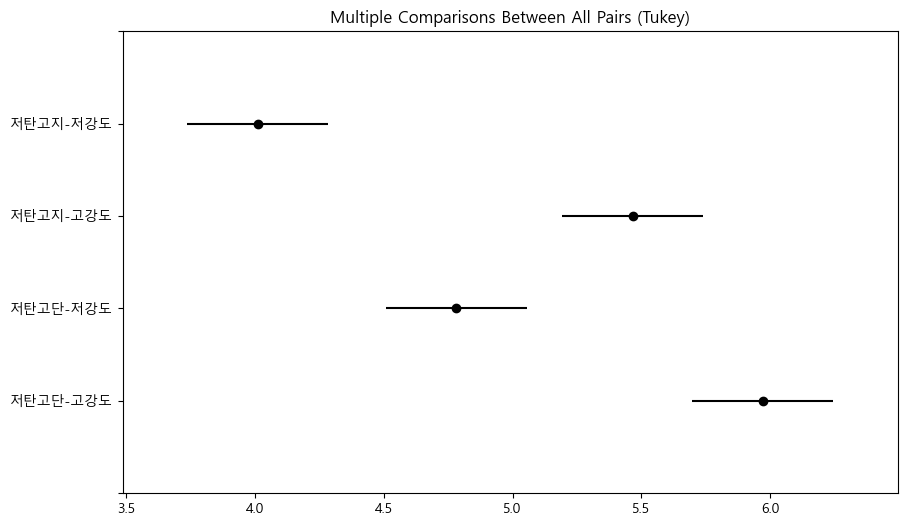

In [854]:
tukeyhsd.plot_simultaneous()
plt.show()

## 통계3
data_path = './data/s3.csv'     
나이와 성별, 급여 관련한 정보이다. 구매여부(Purchased)를 예측하는 로지스틱 회귀 모델을 만드려고 한다.

In [857]:
import pandas as pd
df_s3 =pd.read_csv('./data/s3.csv')
df_s3

,Age,EstimatedSalary,Gender,Purchased
0,22,19000,0,0
1,25,20000,1,0
2,47,43000,0,1
3,52,46000,1,1
4,46,22000,1,0
5,56,80000,0,1
6,55,76000,0,1
7,60,83000,1,1
8,62,81000,1,1
9,61,89000,0,1


### 통계3-1
---
<모델학습조건>    
0,2,3,4의 인덱스 데이터를 테스트 데이터로 하고 나머지 행을 학습데이터로 한다.     
학습데이터에 Gender를 더미화하고 나이와 봉급은 표준화(Standardization) 하라.     
---
로지스틱 회귀 모델을 학습하고 모델 평가를 실시하여 결과를 출력하라. 훈련데이터와 평가데이터에 대한 각각의 accuracy 값을 출력하라.    

In [1038]:
X = df_s3.drop(columns = 'Purchased')
y = df_s3.Purchased

In [1040]:
X = pd.get_dummies(X, columns = ['Gender'])*1

In [1042]:
X_test = X.iloc[[0, 2, 3, 4],:]
X_train = X.loc[~X.index.isin(X_test.index),:]

In [1044]:
y_test = y.iloc[[0, 2, 3, 4]]
y_train = y.loc[~y.index.isin(y_test.index)]

- 데이터 표준화

In [1047]:
from sklearn.preprocessing import StandardScaler

sc_age = StandardScaler()
sc_sal = StandardScaler()

X_train['Age_sc'] = sc_age.fit_transform(X_train[['Age']]).copy()
X_train['EstimatedSalary_sc'] = sc_sal.fit_transform(X_train[['EstimatedSalary']]).copy()

X_test['Age_sc'] = sc_age.transform(X_test[['Age']]).copy()
X_test['EstimatedSalary_sc'] = sc_sal.transform(X_test[['EstimatedSalary']]).copy()

C:\Users\user\AppData\Local\Temp\ipykernel_9444\2490078250.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Age_sc'] = sc_age.fit_transform(X_train[['Age']]).copy()
C:\Users\user\AppData\Local\Temp\ipykernel_9444\2490078250.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['EstimatedSalary_sc'] = sc_sal.fit_transform(X_train[['EstimatedSalary']]).copy()
C:\Users\user\AppData\Local\Temp\ipykernel_9444\2490078250.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [1049]:
X_train_sc = X_train.drop(columns = ['Age','EstimatedSalary'])
X_test_sc = X_test.drop(columns = ['Age','EstimatedSalary'])

In [1051]:
X_train_sc

,Gender_0,Gender_1,Age_sc,EstimatedSalary_sc
1,0,1,-2.191850,-2.204838
5,1,0,0.220482,0.363905
6,1,0,0.142665,0.192656
7,0,1,0.531751,0.492342
8,0,1,0.687385,0.406718
9,1,0,0.609568,0.749217


In [1053]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [1055]:
LR_model = LogisticRegression()

LR_model.fit(X_train_sc, y_train)

LogisticRegression()

- 훈련데이터의 정확도는 1, 시험데이터의 정확도는 0.75로 나타난다.

In [1058]:
LR_train_pred = LR_model.predict(X_train_sc)
LR_test_pred = LR_model.predict(X_test_sc)

print('훈련데이터 accuracy score = ',accuracy_score(y_train, LR_train_pred))
print('시험데이터 accuracy score = ',accuracy_score(y_test, LR_test_pred))

훈련데이터 accuracy score =  1.0
시험데이터 accuracy score =  0.75


### 통계3-2
test데이터에 대해 예측하지 못한 레이블이 있다면 해당 데이터의 레이블 별 예측확률을 추출하라

In [1061]:
y_test == LR_test_pred

0     True
2     True
3     True
4    False
Name: Purchased, dtype: bool

In [1063]:
pred_prob_4 = LR_model.predict_proba(X_test_sc.loc[[4]])
print(f'예측하지 못한 레이블은 4번 인덱스이며, 해당 예측확률은 {pred_prob_4[0][0]:.4f}이다.')

예측하지 못한 레이블은 4번 인덱스이며, 해당 예측확률은 0.4488이다.


### 통계 3-3
새로운 샘플 케이스가 들어왔고 해당 데이터의 더미화 및 표준화의 결과 후 값은 다음과 같다.
| Age  | EstimatedSalary | Gender_0 | Gender_1 |
|------|-----------------|--------|-----------|
| -0.6 | -1.8            | 0      | 1         |     


이 데이터에 대한 모델 결과를 예측하려한다.    
변수별 회귀 계수와 절편값을 통해 계산한 z값과 시그모이드 함수 출력 결과를 각각 구하여라

In [1065]:
b1 = LR_model.coef_[0][0]
b2 = LR_model.coef_[0][1]
b3 = LR_model.coef_[0][2]
b4 = LR_model.coef_[0][3]
a = LR_model.intercept_[0]

In [1067]:
z = a + b1 * 0 + b2 * 1 + b3 * (-0.6) + b4 * (-1.8)
z

0.40027940256284555

In [1071]:
exp_z = np.exp(z)
exp_z

1.4922415755207696

In [1079]:
p = exp_z / (1+exp_z)
print(f'z값 = {z:.4f}, 시그모이드함수 출력 결과 = {p:.4f}')

z값 = 0.4003, 시그모이드함수 출력 결과 = 0.5988


### 통계 3-4
3-1에서 학습한 모델의 각 변수들의 오즈비를 계산하여 출력하고 가장 많은 오즈가 증가하는 피쳐를 확인하라

- 각 변수의 오즈비는 로지스틱 회귀계수에 exp를 취한 것과 같다.
  - 가장 많은 오즈가 증가하는 피쳐는 4번 피쳐(EstimatedSalary)인 것으로 확인된다.
  - 표준화된 EstimatedSalary 한 단위가 증가하면 구매 확률의 오즈는 약 2.02배가 되는 것으로 확인된다.

In [1084]:
odds1 = np.exp(b1)
odds2 = np.exp(b2)
odds3 = np.exp(b3)
odds4 = np.exp(b4)

In [1086]:
odds1, odds2, odds3, odds4 

(1.1703199220299956, 0.8539680777905585, 2.014477381349721, 2.0189248792577654)